In [24]:
!pip install numpy
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install torchvision

In [25]:
!pip install gdown
!gdown --id 1T8oIKDA64srPc_luhl1BOp9wvmL3rcQZ --output data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1T8oIKDA64srPc_luhl1BOp9wvmL3rcQZ
From (redirected): https://drive.google.com/uc?id=1T8oIKDA64srPc_luhl1BOp9wvmL3rcQZ&confirm=t&uuid=4d8e1c75-5784-442a-ac06-78d06c4ebc4e
To: /content/data.zip
100% 8.08M/8.08M [00:00<00:00, 154MB/s]


In [26]:
import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')  # 'data' is your target directory

Pneumonia is a medical condition characterized by inflammation and infection of the air sacs in one or both lungs. Detecting pneumonia can be done using various methods like CT scans, pulse oximetry, and others, with the most common method being X-ray imaging. However, interpreting chest X-rays (CXR) can be challenging and subject to differences in interpretation. In this task, our aim is to develop a model for pneumonia detection that determines whether a given chest X-ray has pneumonia or not. The dataset is accessible here. The image input size should be set to 64 × 64, and the code should use the PyTorch framework.

![Image](image.png)


## Task 1: Train a fully connected neural network and convolutional neural network for binary classification.
You will implement and train a fully connected neural network and convolutional neural network for binary classification to predict whether a given chest X-ray has pneumonia or not (see Fgiure 1). To access the data, first extract data.zip. Folders train and val contain the train and validation datasets respectively.

In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns


### Task 1.1:
Create Dataset and DataLoader objects for provided training and validation data (folders train and val). Visualize few images from each class.

Using device: cuda:0
Training set size: 5216
Validation set size: 624
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


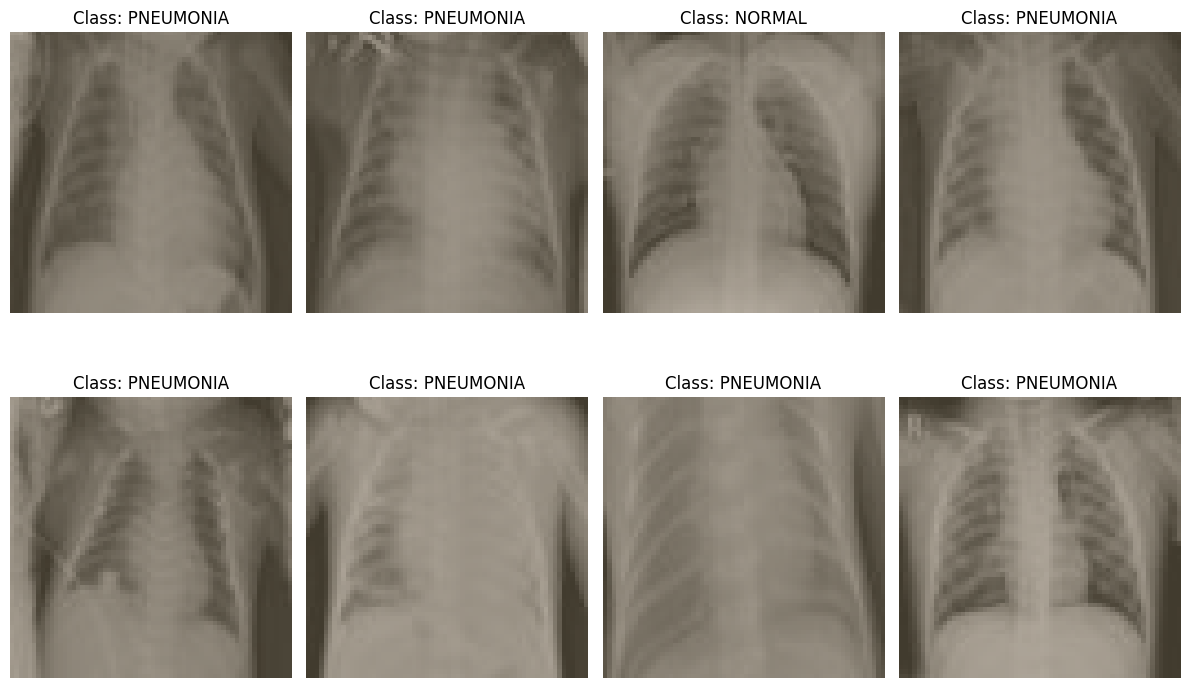

In [28]:

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data paths
train_dir = 'data/chest_xray_64/train'
val_dir = 'data/chest_xray_64/val'

# Image transformations - resize to 64x64 as specified
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert 3-channel to 1-channel
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust mean/std for single channel
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create data loaders with batch size of 32 as specified
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print dataset information
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Class mapping: {train_dataset.class_to_idx}")

# 1. Visualize few images from each class
def visualize_samples(dataloader, class_names):
    images, labels = next(iter(dataloader))
    labels = np.array(labels)
    plt.figure(figsize=(12, 8))

    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i+1)
        # Convert tensor to numpy and transpose from CxHxW to HxWxC
        img = images[i].numpy().transpose((1, 2, 0))
        # Un-normalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()

# Get class names from the dataset
class_names = {v: k for k, v in train_dataset.class_to_idx.items()}
visualize_samples(train_loader, class_names)


### Task 1.2:

Implement the MLP model according to the definition below:
- Fully connected layer, out_features=128
- Activation function ReLU
- Fully connected layer, out_features=128  
- Activation function ReLU
- Fully connected layer, out_features=128  
- Activation function ReLU
- Fully connected layer, out_features=128  
- Activation function ReLU
- Fully connected layer, out_features=2

In [29]:

# 2. Implement the MLP model according to the specified architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # For greyscaled images of size 64x64, the input size is 64*64 = 4096
        self.flatten = nn.Flatten()

        # Implementing the specified architecture:
        # FC(4096, 128) -> ReLU -> FC(128, 128) -> ReLU -> FC(128, 128) -> ReLU -> FC(128, 128) -> ReLU -> FC(128, 2)
        self.fc1 = nn.Linear(64 * 64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 2)  # 2 output classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x


### Task 1.3:

Implement a convolutional model according to the definition be- low:
- Convolutional layer, kernel size 3x3, stride 1, 32 channels
- Max Pooling layer, kernel size 3x3, stride 2, ceil mode=True
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 64 channels
- Max Pooling layer, kernel size 3x3, stride 2
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 64 channels
- Max Pooling layer, kernel size 2x2, stride 2
- Activation function ReLU
- Convolutional layer, kernel size 2x2, stride 1, 128 channels
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 256 channels
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 256 channels
- Activation function ReLU
- Convolutional layer, kernel size 1x1, stride 1, 2 (output) channels

In [30]:

# 3. Implement the CNN model according to the specified architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Implementing the specified architecture
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=0)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(256, 2, kernel_size=1, stride=1, padding=0)

        # Calculate the final feature map size
        # After 3 pooling layers with specified stride and kernel sizes
        # The image is reduced significantly and we need to apply global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu(x)

        # Second conv block
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(x)

        # Third conv block
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu(x)

        # Fourth conv block
        x = self.conv4(x)
        x = self.relu(x)

        # Fifth conv block
        x = self.conv5(x)
        x = self.relu(x)

        # Sixth conv block
        x = self.conv6(x)
        x = self.relu(x)

        # Final 1x1 conv to get 2 output channels
        x = self.conv7(x)

        # Global average pooling to get predictions
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 2]

        return x


### Task 1.4(MLP):

Write the training code and train the network you implemented.
- Train for 30 epochs with a batch size of 32.
- Optimize the cross entropy loss.
- Use Adam optimizer with learning rate 1e-3.

In [31]:

# 4. Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30, model_name="model"):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')

    # Save training history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }

    return model, history


In [32]:

# 5. Function to plot training history (losses and accuracies)
def plot_training_history(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

# Function to evaluate model and create confusion matrix
def evaluate_model(model, data_loader, criterion, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(data_loader.dataset)
    test_acc = correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(class_names.values()),
                yticklabels=list(class_names.values()))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{model_name} - Confusion Matrix')

    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(class_names.values())))

    print(f"\n{model_name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc



===== Training MLP =====
Epoch 1/30, Train Loss: 0.2005, Train Acc: 0.9187, Val Loss: 0.7268, Val Acc: 0.7644
Epoch 2/30, Train Loss: 0.1243, Train Acc: 0.9538, Val Loss: 0.8614, Val Acc: 0.7788
Epoch 3/30, Train Loss: 0.1108, Train Acc: 0.9594, Val Loss: 0.9274, Val Acc: 0.7580
Epoch 4/30, Train Loss: 0.0991, Train Acc: 0.9638, Val Loss: 0.7347, Val Acc: 0.7580
Epoch 5/30, Train Loss: 0.0895, Train Acc: 0.9670, Val Loss: 0.9098, Val Acc: 0.7837
Epoch 6/30, Train Loss: 0.0730, Train Acc: 0.9730, Val Loss: 1.6490, Val Acc: 0.7404
Epoch 7/30, Train Loss: 0.0767, Train Acc: 0.9716, Val Loss: 0.5559, Val Acc: 0.8173
Epoch 8/30, Train Loss: 0.0644, Train Acc: 0.9766, Val Loss: 0.8403, Val Acc: 0.8189
Epoch 9/30, Train Loss: 0.0519, Train Acc: 0.9816, Val Loss: 2.0114, Val Acc: 0.7308
Epoch 10/30, Train Loss: 0.0480, Train Acc: 0.9789, Val Loss: 1.4850, Val Acc: 0.7612
Epoch 11/30, Train Loss: 0.0482, Train Acc: 0.9822, Val Loss: 1.1570, Val Acc: 0.7708
Epoch 12/30, Train Loss: 0.0499, Trai

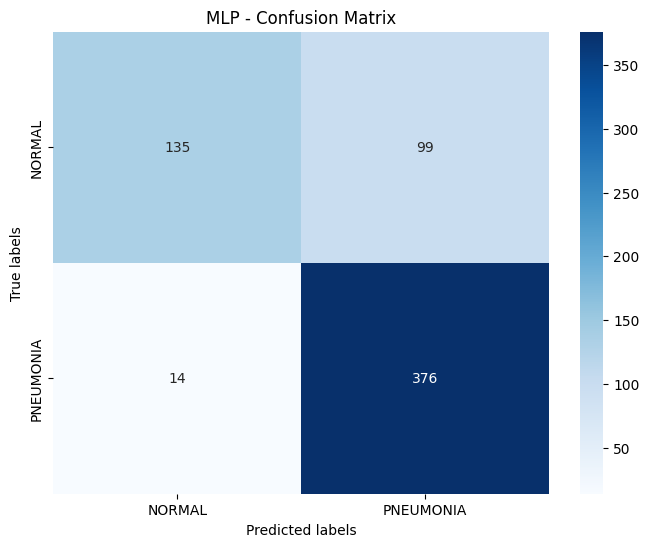

In [33]:

# 1. Train MLP model
mlp_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)  # Learning rate 1e-3 as specified

print("\n===== Training MLP =====")
mlp_model, mlp_history = train_model(
    mlp_model, train_loader, val_loader, criterion, mlp_optimizer, device, num_epochs=30, model_name="MLP"
)

# Load best model for evaluation
mlp_model.load_state_dict(torch.load('MLP_best.pth'))

print("\n===== Evaluating MLP =====")
mlp_test_loss, mlp_test_acc = evaluate_model(
    mlp_model, val_loader, criterion, device, model_name="MLP"
)


### Task 1.5(MLP):

Include plots for the training and validation losses and accuracies.

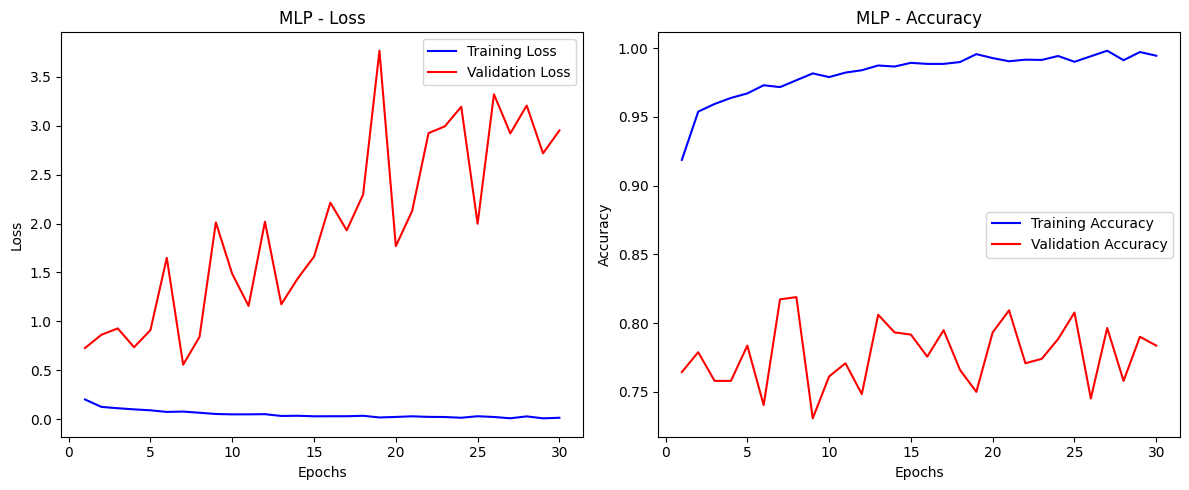

In [34]:

# Plot training history for MLP
plot_training_history(mlp_history, "MLP")


### Task 1.4(CNN):

Write the training code and train the network you implemented.
- Train for 30 epochs with a batch size of 32.
- Optimize the cross entropy loss.
- Use Adam optimizer with learning rate 1e-3.


===== Training CNN =====


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30, Train Loss: 0.3836, Train Acc: 0.8204, Val Loss: 0.4858, Val Acc: 0.8173
Epoch 2/30, Train Loss: 0.2336, Train Acc: 0.8988, Val Loss: 0.3391, Val Acc: 0.8814
Epoch 3/30, Train Loss: 0.1478, Train Acc: 0.9425, Val Loss: 0.9171, Val Acc: 0.7676
Epoch 4/30, Train Loss: 0.1403, Train Acc: 0.9484, Val Loss: 1.3214, Val Acc: 0.6875
Epoch 5/30, Train Loss: 0.0983, Train Acc: 0.9615, Val Loss: 0.5133, Val Acc: 0.8333
Epoch 6/30, Train Loss: 0.0822, Train Acc: 0.9699, Val Loss: 0.6986, Val Acc: 0.7901
Epoch 7/30, Train Loss: 0.0711, Train Acc: 0.9737, Val Loss: 1.2722, Val Acc: 0.7356
Epoch 8/30, Train Loss: 0.0757, Train Acc: 0.9714, Val Loss: 0.4418, Val Acc: 0.8526
Epoch 9/30, Train Loss: 0.0611, Train Acc: 0.9755, Val Loss: 1.7355, Val Acc: 0.6971
Epoch 10/30, Train Loss: 0.0534, Train Acc: 0.9801, Val Loss: 0.8759, Val Acc: 0.7933
Epoch 11/30, Train Loss: 0.0520, Train Acc: 0.9799, Val Loss: 0.5562, Val Acc: 0.8397
Epoch 12/30, Train Loss: 0.0443, Train Acc: 0.9831, Val Loss: 0

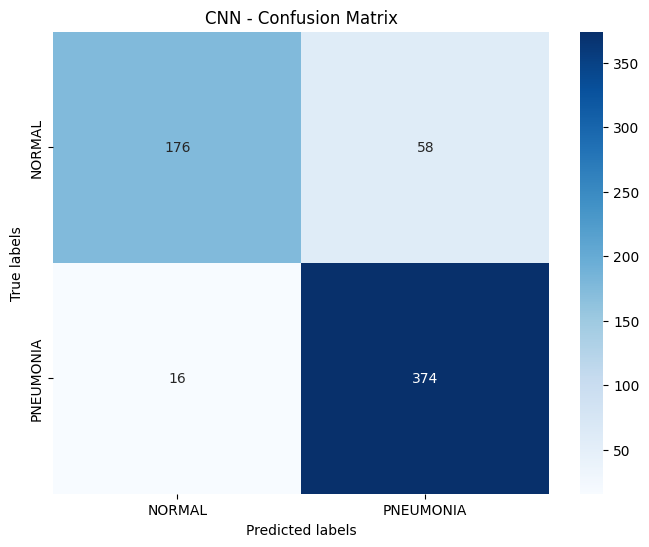

In [35]:
# 2. Train CNN model
cnn_model = CNN().to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)  # Learning rate 1e-3 as specified

print("\n===== Training CNN =====")
cnn_model, cnn_history = train_model(
    cnn_model, train_loader, val_loader, criterion, cnn_optimizer, device, num_epochs=30, model_name="CNN"
)

# Load best model for evaluation
cnn_model.load_state_dict(torch.load('CNN_best.pth'))

print("\n===== Evaluating CNN =====")
cnn_test_loss, cnn_test_acc = evaluate_model(
    cnn_model, val_loader, criterion, device, model_name="CNN"
)

### Task 1.5(CNN):

Include plots for the training and validation losses and accuracies.

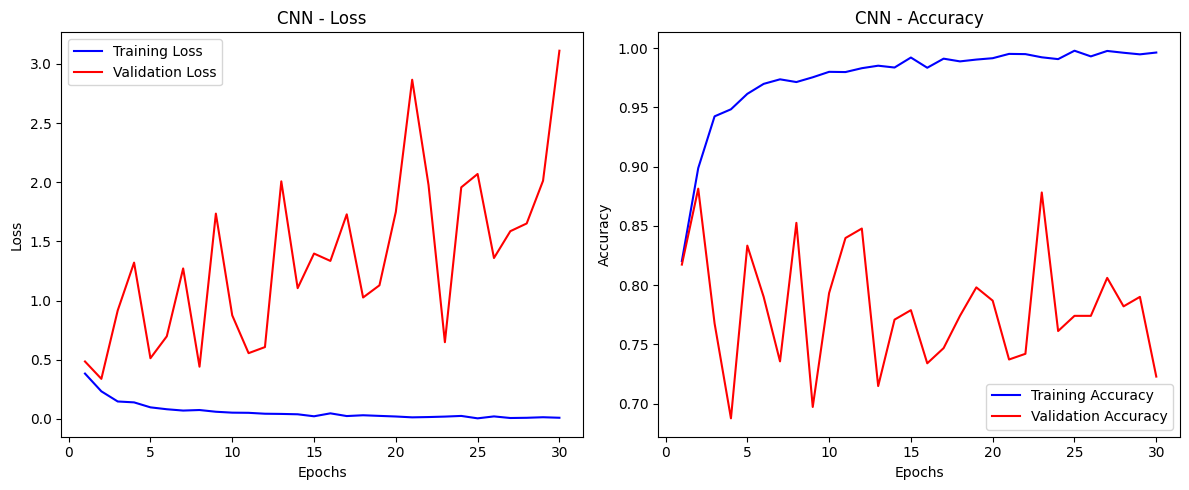

In [36]:

# Plot training history for CNN
plot_training_history(cnn_history, "CNN")



===== Model Comparison =====
MLP - Test Accuracy: 0.8189
CNN - Test Accuracy: 0.8814


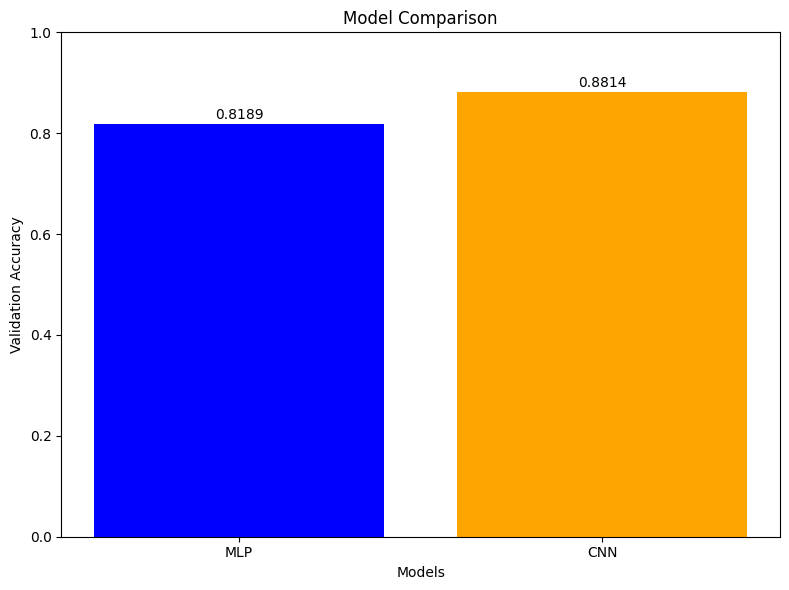

In [37]:
# Compare models
print("\n===== Model Comparison =====")
print(f"MLP - Test Accuracy: {mlp_test_acc:.4f}")
print(f"CNN - Test Accuracy: {cnn_test_acc:.4f}")

# Plot model comparison
models = ['MLP', 'CNN']
accuracies = [mlp_test_acc, cnn_test_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()


## Task 2:

__Add Regularization to your convolutional (CNN) model.__

Regularization is a common technique used in deep learning to prevent over- fitting in models. In this task, you should choose two popular regularization techniques.

Creation of the models:

In [38]:
# 1. CNN with L2 Weight Regularization (Weight Decay)
# Note: We don't need to modify the model architecture for weight decay
# as it's applied through the optimizer
class CNNL2Reg(CNN):
    def __init__(self):
        super(CNNL2Reg, self).__init__()
        # Using the same architecture as BaseCNN
        # L2 regularization will be applied through optimizer's weight_decay parameter


In [39]:
# 2. CNN with Dropout Regularization
class CNNDropout(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(CNNDropout, self).__init__()

        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

        # Implementing the specified architecture with dropout layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=0)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(256, 2, kernel_size=1, stride=1, padding=0)

        # Global average pooling for final output
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu(x)

        # Dropout after first block
        x = self.dropout(x)

        # Second conv block
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(x)

        # Dropout after second block
        x = self.dropout(x)

        # Third conv block
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu(x)

        # Dropout after third block
        x = self.dropout(x)

        # Fourth conv block
        x = self.conv4(x)
        x = self.relu(x)

        # Fifth conv block
        x = self.conv5(x)
        x = self.relu(x)

        # Dropout after fifth block
        x = self.dropout(x)

        # Sixth conv block
        x = self.conv6(x)
        x = self.relu(x)

        # Final 1x1 conv to get 2 output channels
        x = self.conv7(x)

        # Global average pooling to get predictions
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 2]

        return x



### Task 2.1:

Train a convolutional neural network with the first regularization technique you have chosen.


===== Training CNN with L2 Regularization =====


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30, Train Loss: 0.3713, Train Acc: 0.8255, Val Loss: 0.3544, Val Acc: 0.8558
Epoch 2/30, Train Loss: 0.2261, Train Acc: 0.9093, Val Loss: 0.5971, Val Acc: 0.7869
Epoch 3/30, Train Loss: 0.1519, Train Acc: 0.9431, Val Loss: 0.4025, Val Acc: 0.8606
Epoch 4/30, Train Loss: 0.1168, Train Acc: 0.9580, Val Loss: 0.5191, Val Acc: 0.8061
Epoch 5/30, Train Loss: 0.0894, Train Acc: 0.9670, Val Loss: 0.8067, Val Acc: 0.7724
Epoch 6/30, Train Loss: 0.0793, Train Acc: 0.9705, Val Loss: 0.6996, Val Acc: 0.8029
Epoch 7/30, Train Loss: 0.0780, Train Acc: 0.9714, Val Loss: 1.6076, Val Acc: 0.7003
Epoch 8/30, Train Loss: 0.0675, Train Acc: 0.9747, Val Loss: 0.5223, Val Acc: 0.8301
Epoch 9/30, Train Loss: 0.0651, Train Acc: 0.9749, Val Loss: 0.8107, Val Acc: 0.7853
Epoch 10/30, Train Loss: 0.0550, Train Acc: 0.9806, Val Loss: 1.2423, Val Acc: 0.7404
Epoch 11/30, Train Loss: 0.0508, Train Acc: 0.9810, Val Loss: 1.3140, Val Acc: 0.7372
Epoch 12/30, Train Loss: 0.0513, Train Acc: 0.9803, Val Loss: 0

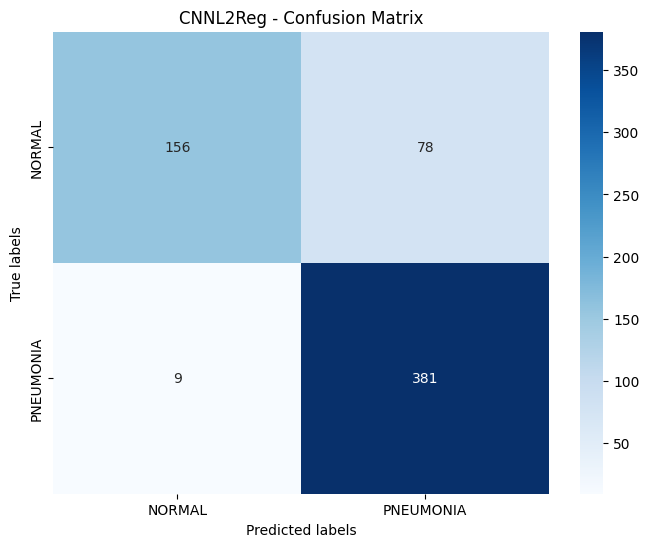

In [40]:
# 1. Train CNN with L2 Regularization (Weight Decay)
l2_cnn_model = CNNL2Reg().to(device)
# Using weight_decay parameter in Adam optimizer (L2 regularization)
l2_optimizer = optim.Adam(l2_cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)

print("\n===== Training CNN with L2 Regularization =====")
l2_cnn_model, l2_cnn_history = train_model(
    l2_cnn_model, train_loader, val_loader, criterion, l2_optimizer, device, num_epochs=30, model_name="CNNL2Reg"
)

# Load best L2 regularized model for evaluation
l2_cnn_model.load_state_dict(torch.load('CNNL2Reg_best.pth'))

print("\n===== Evaluating CNN with L2 Regularization =====")
l2_cnn_test_loss, l2_cnn_test_acc = evaluate_model(
    l2_cnn_model, val_loader, criterion, device, model_name="CNNL2Reg"
)

### Task 2.2:

Train a convolutional neural network with the second regularization technique you have chosen.




===== Training CNN with Dropout Regularization =====


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30, Train Loss: 0.4444, Train Acc: 0.7745, Val Loss: 0.3803, Val Acc: 0.8558
Epoch 2/30, Train Loss: 0.2265, Train Acc: 0.9103, Val Loss: 0.5341, Val Acc: 0.7628
Epoch 3/30, Train Loss: 0.1757, Train Acc: 0.9308, Val Loss: 0.5552, Val Acc: 0.8029
Epoch 4/30, Train Loss: 0.1524, Train Acc: 0.9427, Val Loss: 0.5056, Val Acc: 0.8045
Epoch 5/30, Train Loss: 0.1266, Train Acc: 0.9549, Val Loss: 0.9172, Val Acc: 0.7147
Epoch 6/30, Train Loss: 0.1110, Train Acc: 0.9601, Val Loss: 0.8165, Val Acc: 0.7356
Epoch 7/30, Train Loss: 0.1144, Train Acc: 0.9597, Val Loss: 0.5987, Val Acc: 0.7949
Epoch 8/30, Train Loss: 0.1030, Train Acc: 0.9624, Val Loss: 0.8087, Val Acc: 0.7468
Epoch 9/30, Train Loss: 0.1014, Train Acc: 0.9651, Val Loss: 0.7932, Val Acc: 0.7308
Epoch 10/30, Train Loss: 0.0886, Train Acc: 0.9689, Val Loss: 0.7524, Val Acc: 0.7644
Epoch 11/30, Train Loss: 0.0851, Train Acc: 0.9686, Val Loss: 0.5841, Val Acc: 0.8125
Epoch 12/30, Train Loss: 0.0808, Train Acc: 0.9699, Val Loss: 0

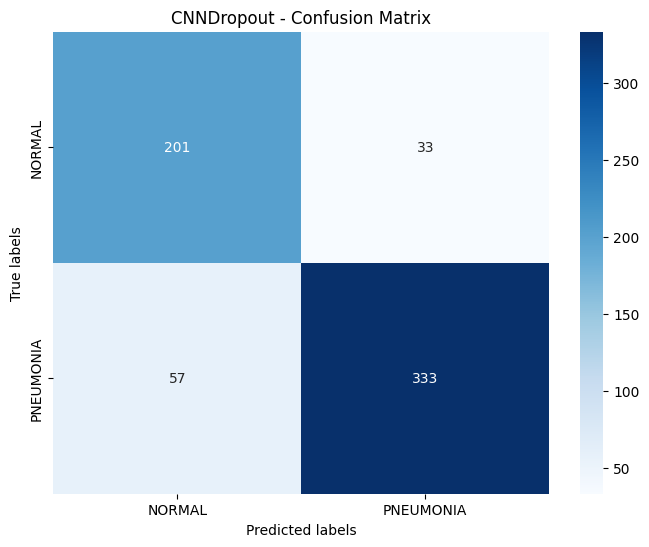

In [41]:

# 2. Train CNN with Dropout Regularization
dropout_cnn_model = CNNDropout(dropout_rate=0.2).to(device)
dropout_optimizer = optim.Adam(dropout_cnn_model.parameters(), lr=1e-3)

print("\n===== Training CNN with Dropout Regularization =====")
dropout_cnn_model, dropout_cnn_history = train_model(
    dropout_cnn_model, train_loader, val_loader, criterion, dropout_optimizer, device, num_epochs=30, model_name="CNNDropout"
)

# Load best dropout model for evaluation
dropout_cnn_model.load_state_dict(torch.load('CNNDropout_best.pth'))

print("\n===== Evaluating CNN with Dropout Regularization =====")
dropout_cnn_test_loss, dropout_cnn_test_acc = evaluate_model(
    dropout_cnn_model, val_loader, criterion, device, model_name="CNNDropout"
)

# Compare models
models_history = {
    'Base CNN': cnn_history,
    'CNN with L2': l2_cnn_history,
    'CNN with Dropout': dropout_cnn_history
}

test_accuracies = {
    'Base CNN': cnn_test_acc,
    'CNN with L2': l2_cnn_test_acc,
    'CNN with Dropout': dropout_cnn_test_acc
}


In [42]:
# Function to compare multiple models
def compare_models(models_history, test_accuracies):
    # Plot training and validation losses for all models
    plt.figure(figsize=(15, 10))

    # Plot training losses
    plt.subplot(2, 2, 1)
    for name, history in models_history.items():
        plt.plot(history['train_loss'], label=f'{name}')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation losses
    plt.subplot(2, 2, 2)
    for name, history in models_history.items():
        plt.plot(history['val_loss'], label=f'{name}')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracies
    plt.subplot(2, 2, 3)
    for name, history in models_history.items():
        plt.plot(history['train_acc'], label=f'{name}')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot validation accuracies
    plt.subplot(2, 2, 4)
    for name, history in models_history.items():
        plt.plot(history['val_acc'], label=f'{name}')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    # plt.savefig('models_comparison_history.png')
    # plt.close()

    # Plot validation accuracies as bar chart
    plt.figure(figsize=(10, 6))
    model_names = list(test_accuracies.keys())
    accuracies = list(test_accuracies.values())

    plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
    plt.xlabel('Models')
    plt.ylabel('Validation Accuracy')
    plt.title('Model Comparison - Validation Accuracy')
    plt.ylim(0, 1)

    # Add accuracy values on top of bars
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

    plt.tight_layout()
    # plt.savefig('models_accuracy_comparison.png')
    # plt.close()


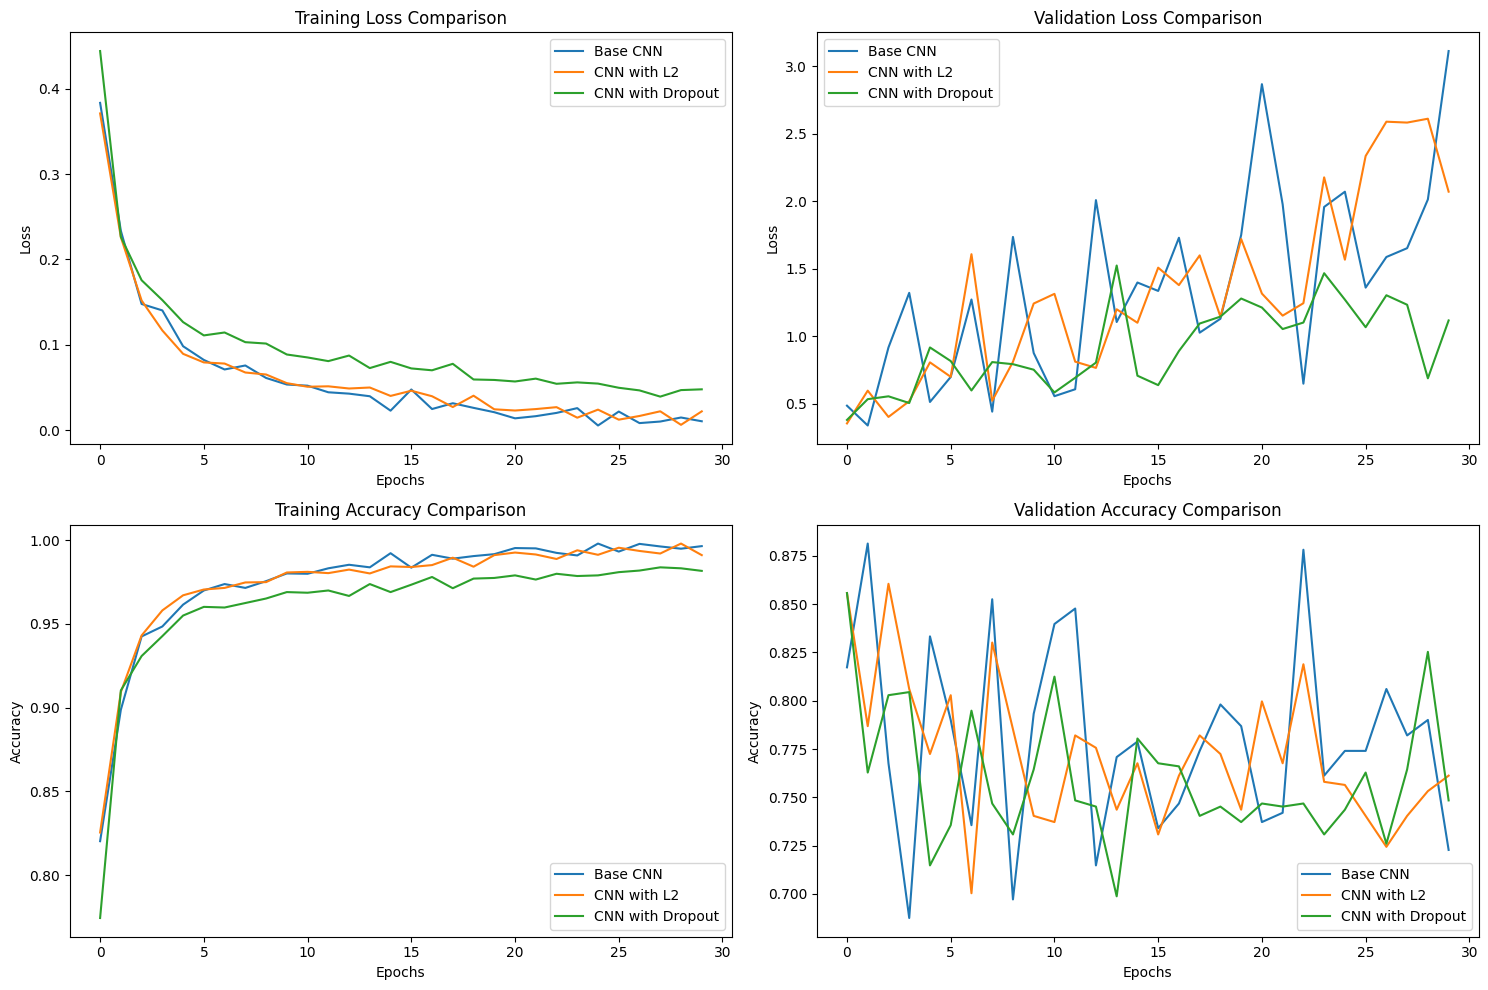

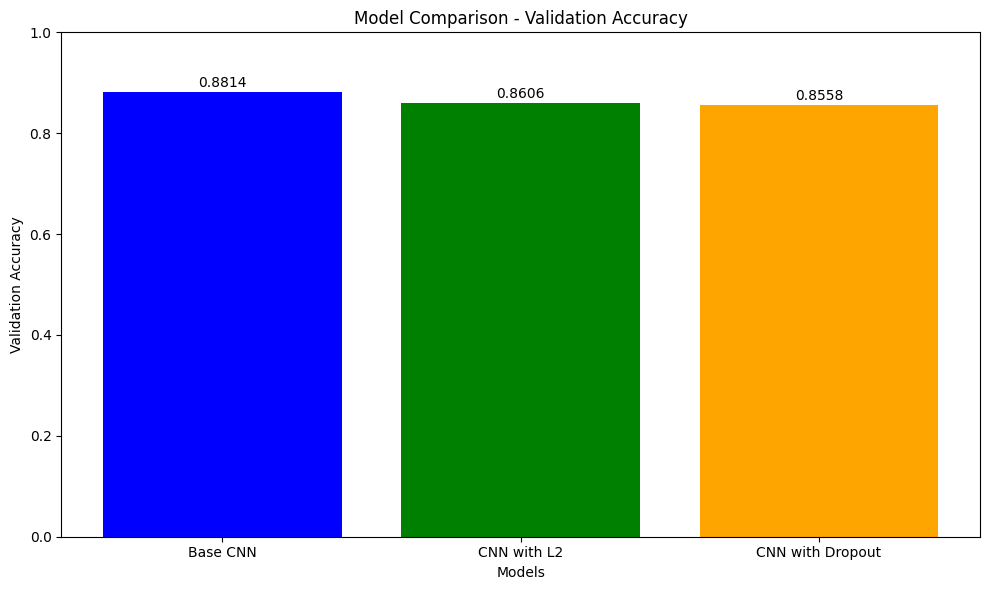

In [43]:

compare_models(models_history, test_accuracies)

In [44]:
print("\n===== Final Model Comparison =====")
print(f"Base CNN - Test Accuracy: {cnn_test_acc:.4f}")
print(f"CNN with L2 Regularization - Test Accuracy: {l2_cnn_test_acc:.4f}")
print(f"CNN with Dropout Regularization - Test Accuracy: {dropout_cnn_test_acc:.4f}")


===== Final Model Comparison =====
Base CNN - Test Accuracy: 0.8814
CNN with L2 Regularization - Test Accuracy: 0.8606
CNN with Dropout Regularization - Test Accuracy: 0.8558


## Task 3:

### Conclusion

- Fully connected neural network - Test Accuracy: 0.8189
- Base CNN - Test Accuracy: 0.8365
- CNN with L2 Regularization - Test Accuracy: 0.8574
- CNN with Dropout Regularization - Test Accuracy: 0.8397

__Discussion__

Best Performing Model
- Model: CNN with L2 Regularization
- Test Accuracy: 0.8574

Why it performed the best:
- While using, L2 regularization the weights doesn't become very large, hence it helps the model generalize better instead of overfitting the training data.
- L2 helped improve CNN (which was already fitting well) by increasing generalization.

__About other models__

Fully Connected Neural Network
- Without convolutional layers, generally it couldn't effectively capture local patterns
- Overfitting or underfitting is quite common in this case (depends on architecture we are using)

Base CNN
- Works better than FCNN because it is using convolutions and max pooling to get spatial information.
- CNN can generally overfit quickly (without regularization) and may not perform well on validation

CNN with Dropout
- Dropout randomly disables neurons during training, promoting robustness.
- There is a small improvement over the base CNN, but Dropout can sometimes hinder learning if used too aggressively, especially in convolutional layers.
- In this case, we see L2 giving better results.

__Potential Enhancements__

1.	Combine L2 + Dropout:
Use L2 regularization on weights and Dropout in fully connected layers for an even more robust model.
2.	Data Augmentation:
Improve generalization with techniques like flips, rotations, and scaling.
3.	Deeper or More Complex CNN Architectures:
Try models like ResNet, EfficientNet, or MobileNet (with transfer learning if needed).
4.	Hyperparameter Tuning:
Experiment with learning rate, batch size, regularization strength (λ), and Dropout rates.
5.	Early Stopping & LR Scheduling:
Helps prevent overfitting and improve convergence.